In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Runge Kutta Methods

In [67]:
def RK(y0,x0,xf,h,f,A,b,c):
    """ This function implements an arbitrary explicity Runge Kutta method. 
    y0= initial condit
    [x0,xf] = interval of interest
    h = target step size; will be adjusted depending on interval length
    f(t,y(t)) = y'(t)
    A,b,c: parameters describing Runge Kutta method. 
    """


    if h <=0:
        raise ValueError('h must be > 0')
    elif x0 >= xf:
        raise ValueError('x0 < xf')
    else:
        L=xf-x0
        numSteps = max(1, int(np.round((xf - x0) / h)))
        h= L/numSteps
    if A.shape[0] != A.shape[1]:
        raise ValueError("A must be square")
    else:
        s = A.shape[0]
        if (b.shape[0] != s) or (c.shape[0] != s):
            raise ValueError("b or c does not have the proper dimensions to match A.")

    # want numSteps total steps counting the last endpoint but not the first
    xis= np.linspace(x0,xf,numSteps+1)
    yis = np.zeros((xis.shape[0],y0.shape[0]))
    yis[0,:] = y0 

    """We will use the implementation described in terms of K_l's on page 19 of the ODE RK slides. 
    While this is an equivalent notation, I prefer it beecause the final y_i+1 falls out of the sum quite nicely. 

    The function below computes y_i+1 from y_i via our RK matrices. 
    """
    def step_RK(i):
        xi = xis[i-1]
        yi = yis[i-1]
        Kls = np.zeros((y0.shape[0],s))
        # print(f"shape of kls = {Kls.shape}")

        # both of these dot products are fine when y: ? \to R, but break down when y is vector valued; we essentially 
        # want the element wise dot product, which we don't have yet 
        # this formula comes directly from the formula on page 19 of the ODE RK slides and the fact that our method is explicit.
        # for l in range(s):
        #     Kls[l] = f(xi+c[l]*h,yi+h*(np.dot(A[l],Kls)))
        # return(yi + h*np.dot(b,Kls))

        for l in range(s):
            # Kls[l] = f(xi+c[l]*h,yi+h*(np.sum(np.array([A[l][j]*Kls[j] for j in range(s)]))) )
            sum = np.sum(A[l]*Kls,axis=1)
            # print(f" shape of sum = {sum.shape}")
            Kls[:,l] = f(xi+c[l]*h,yi+h*(sum))
        return(yi+h*(np.sum(b*Kls,axis=1)))
        # return(yi + h*(np.sum(np.array(b[j]*Kls[j] for j in range(s)))))


    
    for step in range(1,numSteps+1):
        yis[step] = step_RK(step)

    

    return xis,yis,h

# Multistep Methods

In [68]:
def AB(y0,x0,xf,h,f,alphas,betas):

    """This function can execute any explicit Adams-Bashforth method.
    y0=initial condit
    [x0,xf] = interval of interest
    h = target step size; will be adusted depending on interval length
    f(t,y(t)) = y'(t)
    alphas,betas: parameters determining which A,B method you're using"""

    if h <=0:
        raise ValueError('h must be > 0')
    elif x0 >= xf:
        raise ValueError('x0 < xf')
    else:
        L=xf-x0
        numSteps = max(1, int(np.round((xf - x0) / h)))
        h= L/numSteps
    if alphas.shape[0] != betas.shape[0]:
        raise ValueError("alphas and betas must have same length")
    elif betas[-1] != 0.0:
        raise ValueError("explicit methods require beta[m] = 0")
    else:
        # the step count of our method
        m = alphas.shape[0]-1

    # want numSteps total steps counting the last endpoint but not the first
    xis= np.linspace(x0,xf,numSteps+1,dtype=np.float64)
    yis = np.zeros((xis.shape[0],y0.shape[0]),dtype=np.float64)
    yis[0,:] = y0 

    # fill out the first m-1 steps with RK4
    if m > 1:
        # parameters for RK4
        RK4_A = np.zeros((4,4),dtype=np.float64)
        RK4_A[1,0]=.5
        RK4_A[2,1]=.5
        RK4_A[3,2] = 1.0
        RK4_c = np.array([0.0,.5,.5,1.0])
        RK4_b = np.array([1/6,1/3,1/3,1/6])

        xinits,yinits,RK_h=RK(y0=y0,x0=x0,xf = xis[m-1],h=h,f=f,A=RK4_A,b=RK4_b,c=RK4_c)
        yis[0:xinits.shape[0],:] = yinits
        # print(f"RK_h = {RK_h}, while AB_h ={h}; dif = {np.abs(RK_h-h)}")

    # fill out our queue of f evaluations
    fs_stack = np.zeros((m,y0.shape[0]))
    for idx in range(m):
        fs_stack[idx,:] = (f(xis[idx],yis[idx])) 
    
    # now, iterate over the rest of our grid with our method
    for step in range(m,numSteps+1):
        # the RHS of HW equation (5)
        betaFac = h * np.sum(betas[:-1, None] * fs_stack, axis=0)
        # the LHS of HW equation (5), moving all terms but j=m to the RHS
        # alphaFac = -(np.sum(alphas[:-1] * yis[step-m:step,:],axis=0))
        alphaFac = -np.sum(alphas[:-1, None] * yis[step-m:step,:], axis=0)
        # solve for y_i+m
        yis[step] = (betaFac+alphaFac)/alphas[-1]
        # update our queue of fs
        fs_stack[:-1,:] = fs_stack[1:,:]
        fs_stack[-1,:] = f(xis[step],yis[step])


    return xis,yis,h

# Tests

### Test RK4

IVP: $$y' = -2y; \ y(0)=1 \ y \in [0,1]$$

In [69]:
# setup a test of our RK4 method

# rhs
def testRHS(t,y):
    return(-2*y)

# true soln 
def expTest(t):
    return(np.exp(-2*t))

# parameters for RK4
RK4_A = np.zeros((4,4),dtype=np.float32)
RK4_A[1,0]=.5
RK4_A[2,1]=.5
RK4_A[3,2] = 1.0
RK4_c = np.array([0.0,.5,.5,1.0])
RK4_b = np.array([1/6,1/3,1/3,1/6])

y0_parta = np.array([1])

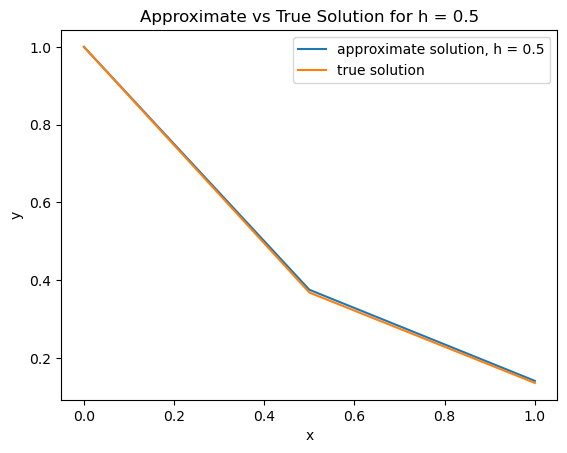

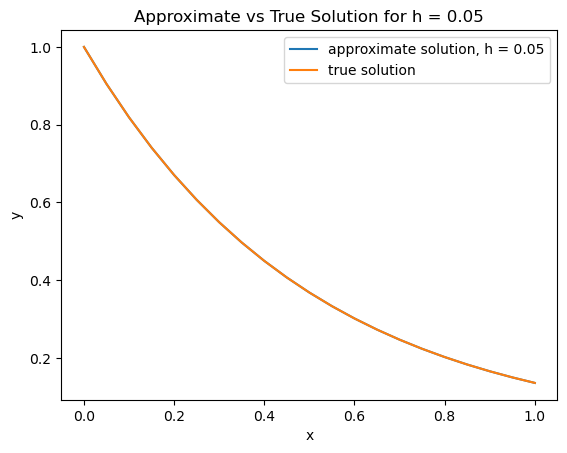

In [70]:
for h in [.5,.05]:
    xis,yis,h = RK(y0=y0_parta,x0=0.0,xf=1.0,h=h,f=testRHS,A=RK4_A,b=RK4_b,c=RK4_c)
    plt.plot(xis,yis,label=f'approximate solution, h = {h}')
    plt.plot(xis,expTest(xis),label='true solution')
    plt.title(f'Approximate vs True Solution for h = {h}')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

### Test Adams Bashforth 2 and 4

IVP: $$y' = -2y; \ y(0)=1 \ y \in [0,1]$$

In [71]:
# parameters for various A-B methods
alphas2 = np.array([0,-1,1])
alphas4 = np.array([0,0,0,-1,1])
betas2 = np.array([-1/2,3/2,0])
betas4 = np.array([-9/24,37/24,-59/24,55/24,0])

# RHS of the difeq for part (a)
def testRHS(t,y):
    return(-2*y)

# true soln of the difeq for part (a)
def expTest(t):
    return(np.exp(-2*t))

y0_parta = np.array([1])

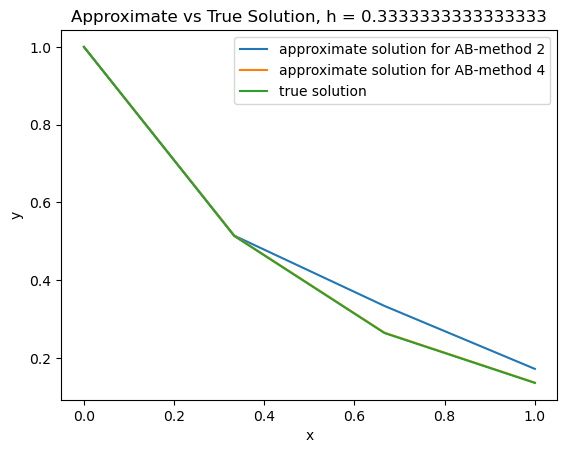

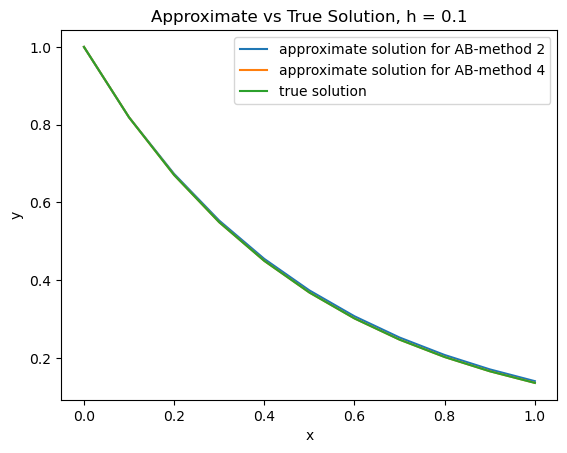

In [74]:
for h in [.3,.1]:
    for method,params in zip([2,4],[[alphas2,betas2],[alphas4,betas4]]):
        # print(f"params = {[p for p in params]}")
        xis,yis,h = AB(y0=y0_parta,x0=0.0,xf=1.0,h=h,f=testRHS,alphas=params[0],betas=params[1])
        plt.plot(xis,yis,label=f'approximate solution for AB-method {method}')
    plt.plot(xis,expTest(xis),label='true solution')
    plt.title(f'Approximate vs True Solution, h = {h}')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()